In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

In [21]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [22]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [23]:
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform)

In [24]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [25]:
# train test split

X = dataset.data.view(-1, 28 * 28).float()
y = dataset.targets

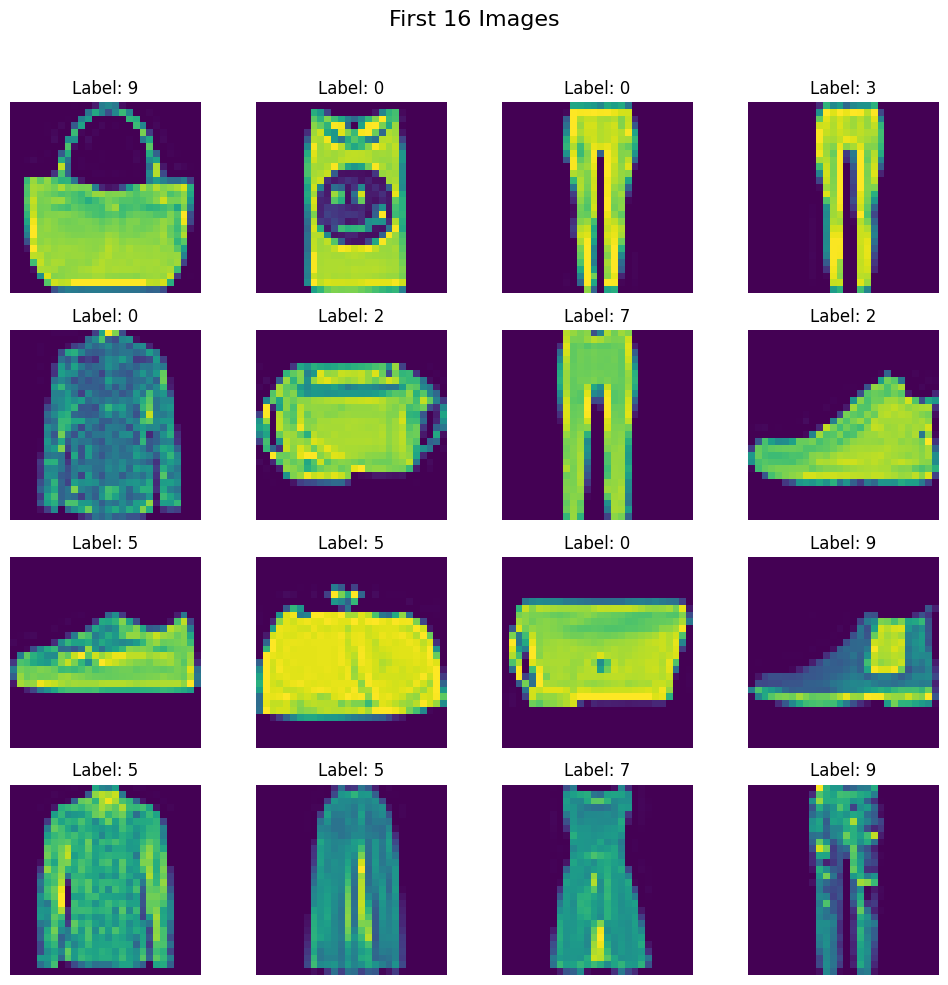

In [26]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)
imgs = X
# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i+100].view(28, 28))
    ax.set_title(f"Label: {y[i].item()}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train = X_train/255.0
X_test = X_test/255.0

In [29]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [30]:
train_dataset = CustomDataset(X_train, y_train)

In [31]:
train_dataset.__len__()

48000

In [32]:
test_dataset = CustomDataset(X_test, y_test)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [34]:
len(train_loader)

1500

In [35]:
class MyNN(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)

    )

  def forward(self, x):

    return self.model(x)


In [36]:
learning_rate = 0.1
epochs = 100

In [37]:
# instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [38]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6324519699513912
Epoch: 2 , Loss: 0.4242698498517275
Epoch: 3 , Loss: 0.3769833765377601
Epoch: 4 , Loss: 0.3502518470336993
Epoch: 5 , Loss: 0.33112380210558573
Epoch: 6 , Loss: 0.3131323919693629
Epoch: 7 , Loss: 0.3008028064419826
Epoch: 8 , Loss: 0.28890989178046583
Epoch: 9 , Loss: 0.2788947898683449
Epoch: 10 , Loss: 0.2686991349210342
Epoch: 11 , Loss: 0.2625127222910523
Epoch: 12 , Loss: 0.25405478932956854
Epoch: 13 , Loss: 0.24582454630980888
Epoch: 14 , Loss: 0.23857022401690484
Epoch: 15 , Loss: 0.2353577812674145
Epoch: 16 , Loss: 0.22722046909853816
Epoch: 17 , Loss: 0.2242438420491914
Epoch: 18 , Loss: 0.21674257975071667
Epoch: 19 , Loss: 0.2120245751303931
Epoch: 20 , Loss: 0.20956287535155813
Epoch: 21 , Loss: 0.20206026666859786
Epoch: 22 , Loss: 0.1984179955913375
Epoch: 23 , Loss: 0.19454391302044194
Epoch: 24 , Loss: 0.1933087683171034
Epoch: 25 , Loss: 0.18572234057448805
Epoch: 26 , Loss: 0.1819976303204894
Epoch: 27 , Loss: 0.1771680211275816

In [39]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [40]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8839166666666667


In [41]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9750208333333333
